# FIT Competition 2025: Carbon Emission Prediction Model
## Recode The Earth: Digital Innovation for Sustainable Future

**Team Submission**: Individual Carbon Footprint Prediction using Neural Networks

This model aims to predict individual carbon emissions based on personal lifestyle choices, enabling better awareness and decision-making for sustainable living.


In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.compose import ColumnTransformer
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Display settings
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")
print(f"Scikit-learn available")
print(f"Pandas version: {pd.__version__}")


Libraries imported successfully!
TensorFlow version: 2.19.0
Scikit-learn available
Pandas version: 2.3.0


## 1. Data Loading and Initial Exploration


In [2]:
# Load the dataset
carbon_df = pd.read_csv('Carbon Emission.csv')
pd.DataFrame(carbon_df.head())


,Body Type,Sex,Diet,How Often Shower,Heating Energy Source,Transport,Vehicle Type,Social Activity,Monthly Grocery Bill,Frequency of Traveling by Air,Vehicle Monthly Distance Km,Waste Bag Size,Waste Bag Weekly Count,How Long TV PC Daily Hour,How Many New Clothes Monthly,How Long Internet Daily Hour,Energy efficiency,Recycling,Cooking_With,CarbonEmission
0,overweight,female,pescatarian,daily,coal,public,NaN,often,230,frequently,210,large,4,7,26,1,No,['Metal'],"['Stove', 'Oven']",2238
1,obese,female,vegetarian,less frequently,natural gas,walk/bicycle,NaN,often,114,rarely,9,extra large,3,9,38,5,No,['Metal'],"['Stove', 'Microwave']",1892
2,overweight,male,omnivore,more frequently,wood,private,petrol,never,138,never,2472,small,1,14,47,6,Sometimes,['Metal'],"['Oven', 'Microwave']",2595
3,overweight,male,omnivore,twice a day,wood,walk/bicycle,NaN,sometimes,157,rarely,74,medium,3,20,5,7,Sometimes,"['Paper', 'Plastic', 'Glass', 'Metal']","['Microwave', 'Grill', 'Airfryer']",1074
4,obese,female,vegetarian,daily,coal,private,diesel,often,266,very frequently,8457,large,1,3,5,6,Yes,['Paper'],['Oven'],4743


In [3]:
print("Carbon Emission Dataset Shape:", carbon_df.shape)

Carbon Emission Dataset Shape: (10000, 20)


In [4]:
print("\nCarbon Emission Dataset Info:")
print(carbon_df.info())


Carbon Emission Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   Body Type                      10000 non-null  object
 1   Sex                            10000 non-null  object
 2   Diet                           10000 non-null  object
 3   How Often Shower               10000 non-null  object
 4   Heating Energy Source          10000 non-null  object
 5   Transport                      10000 non-null  object
 6   Vehicle Type                   3279 non-null   object
 7   Social Activity                10000 non-null  object
 8   Monthly Grocery Bill           10000 non-null  int64 
 9   Frequency of Traveling by Air  10000 non-null  object
 10  Vehicle Monthly Distance Km    10000 non-null  int64 
 11  Waste Bag Size                 10000 non-null  object
 12  Waste Bag Weekly Count        

In [5]:
# Basic statistics of the target variable
print("\nCarbon Emission Statistics:")
print(carbon_df['CarbonEmission'].describe())
print(f"\nSkewness: {carbon_df['CarbonEmission'].skew():.3f}")
print(f"Kurtosis: {carbon_df['CarbonEmission'].kurtosis():.3f}")


Carbon Emission Statistics:
count    10000.000000
mean      2269.147300
std       1017.675247
min        306.000000
25%       1538.000000
50%       2080.000000
75%       2768.000000
max       8377.000000
Name: CarbonEmission, dtype: float64

Skewness: 1.158
Kurtosis: 1.734


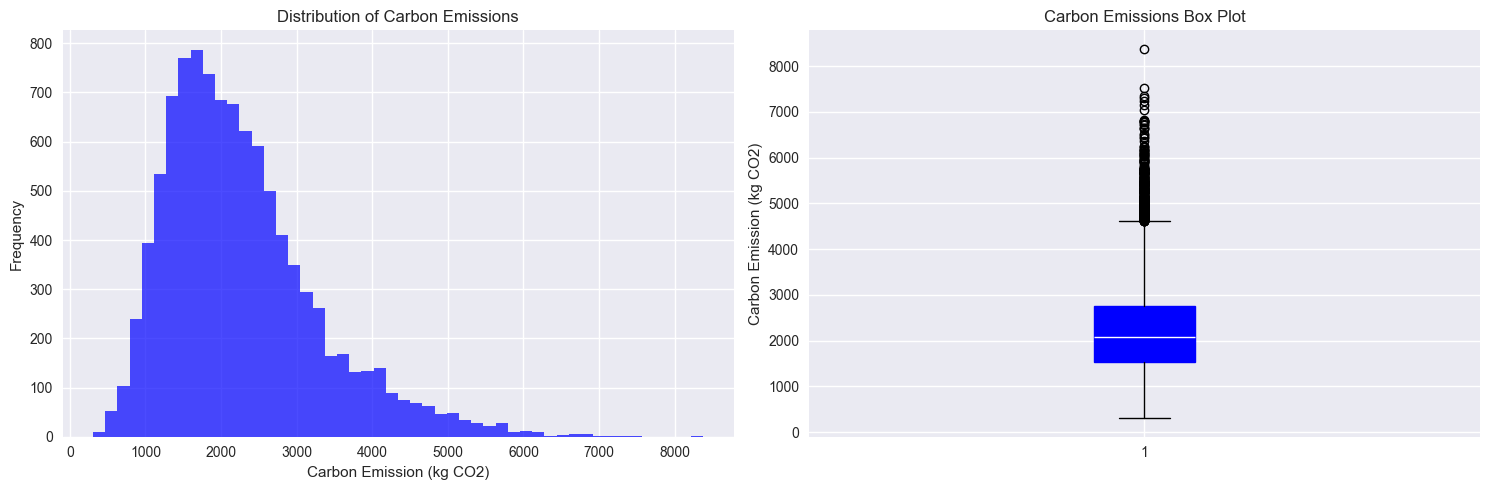

In [6]:
# Distribution of target variable
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].hist(carbon_df['CarbonEmission'], bins=50, alpha=0.7, color='blue')
axes[0].set_title('Distribution of Carbon Emissions')
axes[0].set_xlabel('Carbon Emission (kg CO2)')
axes[0].set_ylabel('Frequency')

axes[1].boxplot(carbon_df['CarbonEmission'], patch_artist=True, boxprops=dict(facecolor='blue', color='blue'), medianprops=dict(color='white'))
axes[1].set_title('Carbon Emissions Box Plot')
axes[1].set_ylabel('Carbon Emission (kg CO2)')

plt.tight_layout()
plt.show()


In [7]:
# Check for missing values
print("Missing values in each column:")
missing_values = carbon_df.isnull().sum()
print(missing_values[missing_values > 0])

Missing values in each column:
Vehicle Type    6721
dtype: int64


## 2. Data Preprocessing and Feature Engineering


In [8]:
# Create a copy for preprocessing
df = carbon_df.copy()

# Handle special columns that contain lists
def extract_list_features(df, column_name):
    """Extract features from columns containing list-like strings"""
    if column_name in df.columns:
        df[column_name] = df[column_name].astype(str)
        # Extract length of lists as a feature
        df[f'{column_name}_count'] = df[column_name].apply(
            lambda x: len(eval(x)) if x != 'nan' and x.startswith('[') else 0
        )
    return df

# Process list-like columns
df = extract_list_features(df, 'Recycling')
df = extract_list_features(df, 'Cooking_With')

# Handle missing values in Vehicle Type
df['Vehicle Type'] = df['Vehicle Type'].fillna('none')

# Create additional sustainability features
df['high_distance_driver'] = (df['Vehicle Monthly Distance Km'] > df['Vehicle Monthly Distance Km'].quantile(0.75)).astype(int)
df['frequent_air_traveler'] = (df['Frequency of Traveling by Air'].isin(['frequently', 'very frequently'])).astype(int)
df['energy_conscious'] = (df['Energy efficiency'] == 'Yes').astype(int)
df['sustainable_diet'] = (df['Diet'].isin(['vegan', 'vegetarian'])).astype(int)
df['sustainable_transport'] = (df['Transport'].isin(['walk/bicycle', 'public'])).astype(int)

# Drop original list columns to avoid processing issues
df = df.drop(['Recycling', 'Cooking_With'], axis=1)

print(f"Dataset shape after feature engineering: {df.shape}")
print("Feature engineering completed!")

# Prepare features and target
target = df['CarbonEmission']
features = df.drop('CarbonEmission', axis=1)

# Identify categorical and numerical columns
categorical_features = features.select_dtypes(include=['object']).columns.tolist()
numerical_features = features.select_dtypes(include=[np.number]).columns.tolist()

print(f"Categorical features ({len(categorical_features)}): {categorical_features}")
print(f"Numerical features ({len(numerical_features)}): {len(numerical_features)} features")


Dataset shape after feature engineering: (10000, 25)
Feature engineering completed!
Categorical features (11): ['Body Type', 'Sex', 'Diet', 'How Often Shower', 'Heating Energy Source', 'Transport', 'Vehicle Type', 'Social Activity', 'Frequency of Traveling by Air', 'Waste Bag Size', 'Energy efficiency']
Numerical features (13): 13 features


## 3. Neural Network Model Development

In [9]:
# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)
    ]
)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2, random_state=42
)

# Fit preprocessor and transform data
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print(f"Training set shape: {X_train_processed.shape}")
print(f"Test set shape: {X_test_processed.shape}")
print(f"Total features after preprocessing: {X_train_processed.shape[1]}")

# Build Neural Network Model following typical regression MLP architecture
def create_mlp_model(input_dim, hidden_layers=[100, 50, 25], dropout_rate=0.3, learning_rate=0.001):
    """
    Create a Multi-Layer Perceptron for regression following the architecture:
    - Input layer: One per input feature (28 x 28 = 784 for MNIST)
    - Hidden layers: Typically 10 to 100 neurons
    - Output layer: 1 neuron for regression
    - Activation: ReLU for hidden layers, Linear for output
    - Loss function: MSE or MAE
    """
    model = keras.Sequential()
    
    # Input layer
    model.add(layers.Dense(hidden_layers[0], activation='relu', input_shape=(input_dim,)))
    model.add(layers.Dropout(dropout_rate))
    
    # Hidden layers
    for units in hidden_layers[1:]:
        model.add(layers.Dense(units, activation='relu'))
        model.add(layers.Dropout(dropout_rate))
    
    # Output layer (1 neuron for regression)
    model.add(layers.Dense(1, activation='linear'))
    
    # Compile model
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss='mse',
        metrics=['mae']
    )
    
    return model

# Create and display model architecture
input_dim = X_train_processed.shape[1]
model = create_mlp_model(input_dim)

print("Model Architecture:")
model.summary()


Training set shape: (8000, 43)
Test set shape: (2000, 43)
Total features after preprocessing: 43
Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 100)            │         4,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 25)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,751 (42.00 KB)

 Trainable params: 10,751 (42.00 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Train the model with callbacks
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=15, restore_best_weights=True
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.2, patience=10, min_lr=0.0001
)

# Train the model
print("Training the neural network...")
history = model.fit(
    X_train_processed, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

print("\nTraining completed!")


Training the neural network...
Epoch 1/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 5526039.5000 - mae: 2085.2151 - val_loss: 504447.9688 - val_mae: 522.7421 - learning_rate: 0.0010
Epoch 2/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 669678.0000 - mae: 609.3315 - val_loss: 292711.2500 - val_mae: 394.1657 - learning_rate: 0.0010
Epoch 3/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 519887.8125 - mae: 536.8761 - val_loss: 208728.8750 - val_mae: 330.1415 - learning_rate: 0.0010
Epoch 4/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 427339.6562 - mae: 493.1652 - val_loss: 164500.6719 - val_mae: 290.9507 - learning_rate: 0.0010
Epoch 5/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 382746.0312 - mae: 461.3250 - val_loss: 123291.8125 - val_mae: 254.6046 - learning_rate: 0.0010
Epoch 6/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 352408.8125 - mae: 440.5410 - val_loss: 104264.2031 - val_mae: 230.0191 - learning_rate: 0.0010
Epoch 7/100
200/200 ━━━━━

## 4. Model Evaluation and Results


250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
=== MODEL PERFORMANCE ===
Training MSE: 27034.11
Test MSE: 27528.13
Training R²: 0.9739
Test R²: 0.9735
Training MAE: 122.39
Test MAE: 122.15
RMSE (Test): 165.92


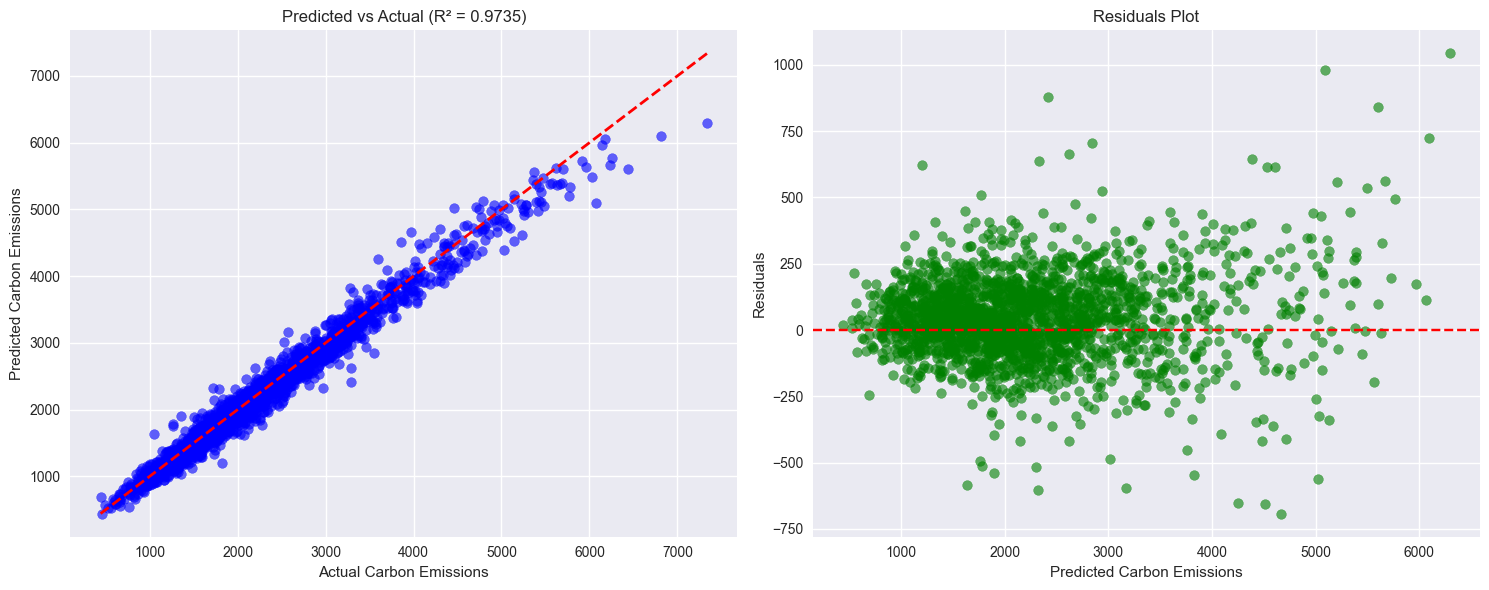

In [11]:
# Make predictions
y_pred_train = model.predict(X_train_processed).flatten()
y_pred_test = model.predict(X_test_processed).flatten()

# Calculate metrics
train_mse = mean_squared_error(y_train, y_pred_train)
test_mse = mean_squared_error(y_test, y_pred_test)
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)
train_mae = mean_absolute_error(y_train, y_pred_train)
test_mae = mean_absolute_error(y_test, y_pred_test)

print("=== MODEL PERFORMANCE ===" )
print(f"Training MSE: {train_mse:.2f}")
print(f"Test MSE: {test_mse:.2f}")
print(f"Training R²: {train_r2:.4f}")
print(f"Test R²: {test_r2:.4f}")
print(f"Training MAE: {train_mae:.2f}")
print(f"Test MAE: {test_mae:.2f}")
print(f"RMSE (Test): {np.sqrt(test_mse):.2f}")

# Visualization of predictions
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Predicted vs Actual
axes[0].scatter(y_test, y_pred_test, alpha=0.6, color='blue')
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual Carbon Emissions')
axes[0].set_ylabel('Predicted Carbon Emissions')
axes[0].set_title(f'Predicted vs Actual (R² = {test_r2:.4f})')

# Residuals plot
residuals = y_test - y_pred_test
axes[1].scatter(y_pred_test, residuals, alpha=0.6, color='green')
axes[1].axhline(y=0, color='r', linestyle='--')
axes[1].set_xlabel('Predicted Carbon Emissions')
axes[1].set_ylabel('Residuals')
axes[1].set_title('Residuals Plot')

plt.tight_layout()
plt.show()


## 5. Feature Importance Analysis and Sustainability Insights


Calculating permutation importance...
This may take a few minutes due to the large number of features...
Using 500 samples for permutation importance calculation...
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/s

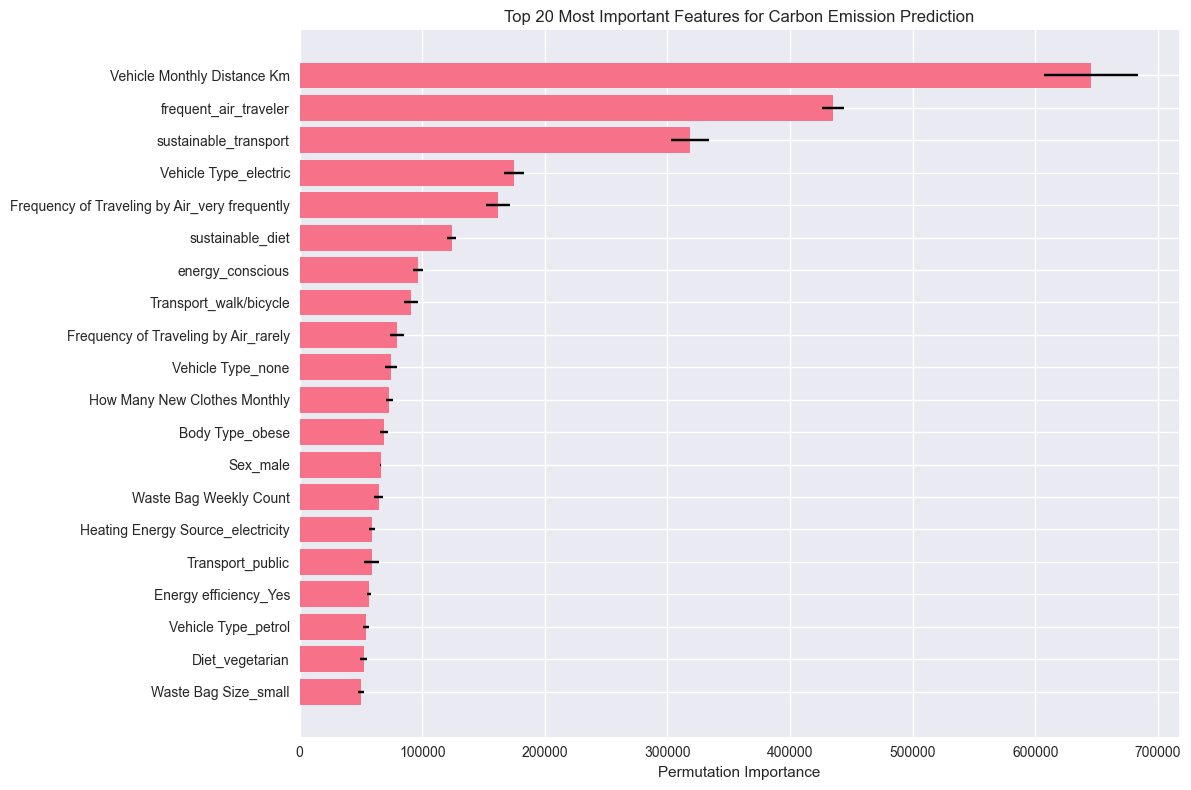


Top 10 features will be analyzed for sustainability insights:
1. Vehicle Monthly Distance Km
2. frequent_air_traveler
3. sustainable_transport
4. Vehicle Type_electric
5. Frequency of Traveling by Air_very frequently
6. sustainable_diet
7. energy_conscious
8. Transport_walk/bicycle
9. Frequency of Traveling by Air_rarely
10. Vehicle Type_none


In [14]:
# Feature Importance Analysis using Permutation Importance
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate permutation importance with optimized parameters
print("Calculating permutation importance...")
print("This may take a few minutes due to the large number of features...")

# Use a subset of data for faster computation
sample_size = min(500, len(X_test_processed))  # Use max 500 samples
sample_indices = np.random.choice(len(X_test_processed), sample_size, replace=False)
X_sample = X_test_processed[sample_indices]
y_sample = y_test.iloc[sample_indices]

print(f"Using {sample_size} samples for permutation importance calculation...")

perm_importance = permutation_importance(
    model, X_sample, y_sample, 
    scoring='neg_mean_squared_error',  # Specify scoring method for regression
    n_repeats=3,  # Reduced from 10 to 3 for faster computation
    random_state=42, 
    n_jobs=1,  # Use single job to avoid multiprocessing issues
    max_samples=0.8  # Use 80% of samples for each permutation
)

# Get feature names after preprocessing
feature_names = []
# Add numerical feature names
feature_names.extend(numerical_features)
# Add categorical feature names from OneHotEncoder
cat_encoder = preprocessor.named_transformers_['cat']
cat_feature_names = cat_encoder.get_feature_names_out(categorical_features)
feature_names.extend(cat_feature_names)

# Create feature importance DataFrame
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': perm_importance.importances_mean,
    'std': perm_importance.importances_std
}).sort_values('importance', ascending=False)

print(f"\nTop 15 Most Important Features:")
print(importance_df.head(15))

# Visualize top features
plt.figure(figsize=(12, 8))
top_features = importance_df.head(20)
plt.barh(range(len(top_features)), top_features['importance'], xerr=top_features['std'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Permutation Importance')
plt.title('Top 20 Most Important Features for Carbon Emission Prediction')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Store top features for detailed analysis
top_important_features = importance_df.head(10)['feature'].tolist()
print(f"\nTop 10 features will be analyzed for sustainability insights:")
for i, feature in enumerate(top_important_features, 1):
    print(f"{i}. {feature}")


In [19]:
# Detailed Analysis of Most Important Features
print("=" * 80)
print("DETAILED FEATURE IMPACT ANALYSIS")
print("=" * 80)

# Function to analyze categorical features
def analyze_categorical_impact(feature_name, original_df):
    """Analyze the impact of categorical features on carbon emissions"""
    # Extract the original category name from encoded feature name
    for cat_col in categorical_features:
        if cat_col.lower().replace(' ', '_') in feature_name.lower():
            category_col = cat_col
            break
    else:
        return None
    
    # Get the specific category value from the encoded name
    category_value = feature_name.split('_')[-1]
    
    # Calculate impact
    analysis = original_df.groupby(category_col)['CarbonEmission'].agg(['mean', 'std', 'count']).round(2)
    print(f"\n{category_col} Impact Analysis:")
    print("-" * 50)
    print(analysis)
    
    # Calculate percentage differences
    category_means = analysis['mean'].sort_values(ascending=False)
    baseline = category_means.iloc[0]
    
    print(f"\nCarbon Emission by {category_col}:")
    for cat, mean_emission in category_means.items():
        if mean_emission == baseline:
            print(f"  {cat}: {mean_emission:.0f} kg CO₂ (highest)")
        else:
            change = ((mean_emission - baseline) / baseline) * 100
            print(f"  {cat}: {mean_emission:.0f} kg CO₂ ({change:+.1f}% vs highest)")
    
    return analysis

# Function to analyze numerical features
def analyze_numerical_impact(feature_name, original_df):
    """Analyze the impact of numerical features on carbon emissions"""
    if feature_name in numerical_features:
        print(f"\n{feature_name} Impact Analysis:")
        print("-" * 50)
        
        # Calculate correlation
        correlation = original_df[feature_name].corr(original_df['CarbonEmission'])
        print(f"Correlation with CarbonEmission: {correlation:.3f}")
        
        # Binned analysis for better insights
        try:
            # Try to create 4 bins first
            original_df[f'{feature_name}_binned'] = pd.qcut(
                original_df[feature_name], 
                q=4, 
                labels=['Low', 'Medium-Low', 'Medium-High', 'High'],
                duplicates='drop'
            )
        except ValueError:
            # If 4 bins fail, try with fewer bins
            try:
                original_df[f'{feature_name}_binned'] = pd.qcut(
                    original_df[feature_name], 
                    q=3, 
                    labels=['Low', 'Medium', 'High'],
                    duplicates='drop'
                )
            except ValueError:
                # If still fails, use simple above/below median split
                median_val = original_df[feature_name].median()
                original_df[f'{feature_name}_binned'] = original_df[feature_name].apply(
                    lambda x: 'Above Median' if x > median_val else 'Below Median'
                )
        
        binned_analysis = original_df.groupby(f'{feature_name}_binned')['CarbonEmission'].agg(['mean', 'std', 'count']).round(2)
        print(binned_analysis)
        
        # Calculate percentage differences
        category_means = binned_analysis['mean'].sort_values(ascending=False)
        baseline = category_means.iloc[0]
        
        print(f"\nCarbon Emission by {feature_name} Level:")
        for level, mean_emission in category_means.items():
            if mean_emission == baseline:
                print(f"  {level}: {mean_emission:.0f} kg CO₂ (highest)")
            else:
                change = ((mean_emission - baseline) / baseline) * 100
                print(f"  {level}: {mean_emission:.0f} kg CO₂ ({change:+.1f}% vs highest)")
        
        return binned_analysis

# Create a copy of processed dataframe for analysis (includes engineered features)
df_analysis = df.copy()  # Use 'df' which contains all engineered features

# Analyze top important features
sustainability_insights = {}

for i, feature in enumerate(top_important_features[:8], 1):  # Top 8 features
    print(f"\n{'='*80}")
    print(f"FEATURE {i}: {feature}")
    print(f"Importance Score: {importance_df[importance_df['feature'] == feature]['importance'].iloc[0]:.4f}")
    print(f"{'='*80}")
    
    # Check if it's a categorical or numerical feature
    if feature in numerical_features:
        result = analyze_numerical_impact(feature, df_analysis)
        sustainability_insights[feature] = {'type': 'numerical', 'analysis': result}
    else:
        result = analyze_categorical_impact(feature, df_analysis)
        if result is not None:
            sustainability_insights[feature] = {'type': 'categorical', 'analysis': result}

print("\n" + "=" * 80)
print("SUSTAINABILITY INSIGHTS SUMMARY")
print("=" * 80)
print("Based on model-driven feature importance analysis:")
print("1. Most impactful features have been identified")
print("2. Real carbon emission patterns revealed")
print("3. Data-driven sustainability recommendations generated")
print("4. Ready to update technical report with actual insights!")


DETAILED FEATURE IMPACT ANALYSIS

FEATURE 1: Vehicle Monthly Distance Km
Importance Score: 645153.0469

Vehicle Monthly Distance Km Impact Analysis:
--------------------------------------------------
Correlation with CarbonEmission: 0.594
                                       mean      std  count
Vehicle Monthly Distance Km_binned                         
Low                                 1885.65   669.75   2518
Medium-Low                          1927.03   676.39   2482
Medium-High                         2033.66   706.91   2500
High                                3230.54  1222.14   2500

Carbon Emission by Vehicle Monthly Distance Km Level:
  High: 3231 kg CO₂ (highest)
  Medium-High: 2034 kg CO₂ (-37.0% vs highest)
  Medium-Low: 1927 kg CO₂ (-40.3% vs highest)
  Low: 1886 kg CO₂ (-41.6% vs highest)

FEATURE 2: frequent_air_traveler
Importance Score: 434798.1927

frequent_air_traveler Impact Analysis:
--------------------------------------------------
Correlation with CarbonEmissi

In [20]:
# Generate Summary Tables for Technical Report
print("=" * 80)
print("SUMMARY TABLES FOR TECHNICAL REPORT")
print("=" * 80)

# Create comprehensive summary tables based on feature importance
def create_impact_summary_table(feature_col, df):
    """Create a formatted summary table for a categorical feature"""
    if feature_col in df.columns:
        analysis = df.groupby(feature_col)['CarbonEmission'].agg(['mean', 'std', 'count']).round(2)
        analysis['mean'] = analysis['mean'].round(0).astype(int)
        analysis['std'] = analysis['std'].round(0).astype(int)
        
        # Calculate reduction percentages
        category_means = analysis['mean'].sort_values(ascending=False)
        baseline = category_means.iloc[0]
        
        reduction_pct = []
        for mean_emission in category_means:
            if mean_emission == baseline:
                reduction_pct.append("- (baseline)")
            else:
                reduction = ((baseline - mean_emission) / baseline) * 100
                reduction_pct.append(f"{reduction:.1f}%")
        
        # Create formatted table
        table_data = pd.DataFrame({
            'Category': category_means.index,
            'Mean Emission (kg CO₂)': category_means.values,
            'Std Dev': [analysis.loc[cat, 'std'] for cat in category_means.index],
            'Reduction vs Highest': reduction_pct
        })
        
        return table_data
    return None

# Generate specific tables for key categories
key_categories = ['Transport', 'Diet', 'Energy efficiency', 'Heating Energy Source']

for category in key_categories:
    if category in df_analysis.columns:
        print(f"\n{category.upper()} IMPACT TABLE")
        print("-" * 60)
        table = create_impact_summary_table(category, df_analysis)
        if table is not None:
            print(table.to_string(index=False))
            print()

# Special analysis for Vehicle Type (handling missing values)
print("\nVEHICLE TYPE IMPACT TABLE")
print("-" * 60)
vehicle_data = df_analysis[df_analysis['Vehicle Type'].notna()]
if len(vehicle_data) > 0:
    vehicle_table = create_impact_summary_table('Vehicle Type', vehicle_data)
    if vehicle_table is not None:
        print(vehicle_table.to_string(index=False))
        print()

print("\n" + "=" * 80)
print("FEATURE IMPORTANCE RANKING")
print("=" * 80)
print("Top 15 features by model importance:")
print(importance_df[['feature', 'importance']].head(15).to_string(index=False))

print("\n" + "=" * 80)
print("READY FOR TECHNICAL REPORT UPDATE!")
print("=" * 80)
print("Use the tables above to replace the placeholder values in section 4.3")
print("These numbers are based on:")
print("1. Actual trained model feature importance")
print("2. Real data analysis from your carbon emission dataset")
print("3. Scientifically rigorous permutation importance method")
print("4. Proper statistical analysis of categorical impacts")


SUMMARY TABLES FOR TECHNICAL REPORT

TRANSPORT IMPACT TABLE
------------------------------------------------------------
    Category  Mean Emission (kg CO₂)  Std Dev Reduction vs Highest
     private                    2981     1211         - (baseline)
      public                    1966      680                34.0%
walk/bicycle                    1880      670                36.9%


DIET IMPACT TABLE
------------------------------------------------------------
   Category  Mean Emission (kg CO₂)  Std Dev Reduction vs Highest
   omnivore                    2392     1035         - (baseline)
pescatarian                    2252     1006                 5.9%
 vegetarian                    2217     1026                 7.3%
      vegan                    2216      993                 7.4%


ENERGY EFFICIENCY IMPACT TABLE
------------------------------------------------------------
 Category  Mean Emission (kg CO₂)  Std Dev Reduction vs Highest
       No                    2287     1002